In [24]:
import pyro
import pyro.distributions as dist
import torch
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
import torch.nn.functional as F
import generate_toy_data as data
import math
from tqdm import trange

# import classes
from pyro.infer import SVI, TraceMeanField_ELBO
import model_signals_only as MSO
import model_signals_only_fixedBeta as MSB
import model_signals_and_refState as MSR
import model_signals_refStates_fixedBeta as MSRB

import os 
import helper
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# setting up devices
seed = 0
torch.manual_seed(seed)
pyro.set_rng_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [25]:
num_bins = 10000
num_references = 3
num_groups = 3
state_vary_rate = 0.01
num_signals= 3
num_states = 3
output_folder = '../../experiments/strict_genData_circularState/b{}_r{}_m{}_s{}'\
.format(num_bins, num_references, num_signals, num_states)
helper.make_dir(output_folder)

Folder../../experiments/strict_genData_circularState/b10000_r3_m3_s3 is already created


In [26]:
generator_params = {'num_bins': num_bins, 'num_references': num_references, 'num_groups': num_groups, \
                    'state_vary_rate': state_vary_rate, 'num_signals': num_signals, 'num_states': num_states}

toy_params = {
    'num_bins': num_bins,
    'num_references': num_references,
    'num_signals': num_signals,
    'num_states': num_states
}
generator = data.CircularStateGenerator(**generator_params, high_w=100) 
# CircularStateGenerator generates simulation data such that each group of reference epigenomes will have 
# different chromatin state annotations. And the state annotations vary across the genome for each ref.epig
# generator = data.ToyGenerator(**toy_params, high_w) # uncomment this line if want to try a different generator
# ToyGenerator generates simulation data such that each refernece epingeome will be assigned to the same state 
# across the genome, but the state assicated with each refernece epig is different across ref.epigs.

'''
M: # regions
N: # bins per region
L: # signals (marks)
alpha: params of dirichlet prior over reference epigenomics
beta: ref --> sample state categorical distribution
p: state --> signal bernoulli distribution 
r: reference state at each bin. one-hot encoding, matrix size : #bins * #ref * #states
theta: the mixture probabilities of reference epigenome
'''
m = generator.get_sampled_signals()
r = generator.get_ref_state_indicators()
p = generator.params['p']
# this will save the simulated data of state assignment 
# (ground truth state assignment probabilities)
generator.save_collapsed_theta(os.path.join(output_folder, 'collapsed_theta.txt.gz'))


Setting up all the models 

In [27]:
hidden = 32
dropout = 0.2
# declare 4 models with similar parameters
m_SigOnly = MSO.model_Signals(num_signals, num_references, num_states, hidden, dropout)
m_SigBeta = MSB.model_signals_only_fixedBeta(num_signals, num_references, num_states, hidden, dropout, p)
m_SigRef = MSR.model_signals_refStates(num_signals, num_references, num_states, hidden, dropout)
m_SigRefBeta = MSRB.model_signals_refStates_fixedBeta(num_signals, num_references, num_states, hidden, dropout, p)
m_SigOnly.to(device)
m_SigBeta.to(device)
m_SigRef.to(device)
m_SigRefBeta.to(device)
print(isinstance(m_SigOnly, (type, MSO.model_Signals)))
print(isinstance(m_SigBeta, (type, MSB.model_signals_only_fixedBeta)))
print(isinstance(m_SigRef, (type, MSR.model_signals_refStates)))
print(isinstance(m_SigRefBeta, (type, MSRB.model_signals_refStates_fixedBeta)))

True
True
True
True


Define a function to learn and reconstruct the data, and gives the results of ratios of the data that gets reconstructed

In [28]:
def learn_and_reconstruct_input(state_model, m, r, p, posterior_fn):
    batch_size = 200
    learning_rate = 1e-3
    num_epochs = 1#000
    pyro.clear_param_store()
    optimizer = pyro.optim.Adam({"lr": learning_rate})
    num_batches = int(math.ceil(m.shape[0] / batch_size))
    bar = trange(num_epochs)
    withRef = True # some models needs reference states data, others don't
    if isinstance(state_model, (type, MSO.model_Signals)) or isinstance(state_model, (type, MSB.model_signals_only_fixedBeta)):
        withRef = False 
    svi = SVI(state_model.model, state_model.guide, optimizer, loss=TraceMeanField_ELBO())
    for epoch in bar:
        running_loss = 0.0
        for i in range(num_batches):
            batch_m = m[i * batch_size:(i+1) * batch_size, :]
            if withRef:
                batch_r = r[i * batch_size:(i+1) * batch_size, :, :]
                loss = svi.step(batch_m, batch_r)
            else:
                loss = svi.step(batch_m)
            running_loss += loss / batch_m.size(0)
    bar.set_postfix(epoch_loss='{:.2e}'.format(running_loss))
    if withRef:
        ratio_m_CR, ratio_r_CR = state_model.get_percentage_correct_reconstruct(m,r)
        state_model.write_predicted_state_assignment(m, r, posterior_fn)
        return ratio_m_CR, ratio_r_CR
    else:
        ratio_m_CR = state_model.get_percentage_correct_reconstruct(m)
        state_model.write_predicted_state_assignment(m, posterior_fn)
        return ratio_m_CR, 0 # return 0 as a placeholder for ratio_r_CR that is not applicable for this case


REPORT THE OUTPUT DATA

In [29]:
result_df = pd.DataFrame(columns = ['model', 'num_signals', 'num_references', 'num_states', 'hidden', 'dropout', 'ratio_m_CR', 'ratio_r_CR'])
def get_one_line_to_report(state_model, model_name):
    results = [model_name, state_model.num_signals, state_model.num_references, state_model.num_states, state_model.hidden, state_model.dropout]
    posterior_fn = os.path.join(output_folder, '{}_pos.txt.gz'.format(model_name))
    ratio_m_CR, ratio_r_CR = learn_and_reconstruct_input(state_model, m, r, p, posterior_fn)
    results += [ratio_m_CR, ratio_r_CR]
    return results

result_df.loc[0] = get_one_line_to_report(m_SigOnly, 'SigOnly')
result_df.loc[1] = get_one_line_to_report(m_SigBeta, 'SigBeta')
result_df.loc[2] = get_one_line_to_report(m_SigRef, 'SigRef')
result_df.loc[3] = get_one_line_to_report(m_SigRefBeta, 'SigRefBeta')
report_fn = os.path.join(output_folder, 'report_ratio_CR.txt')
result_df.to_csv(report_fn, header = True, index = False, sep = '\t')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]


In [30]:
# the fn that contains posterior probabilities of state assignments at different models
truth_fn = os.path.join(output_folder,'collapsed_theta.txt.gz')
sigOnly_fn = os.path.join(output_folder, 'SigOnly_pos.txt.gz')
sigBeta_fn = os.path.join(output_folder, 'SigBeta_pos.txt.gz')
sigRefBeta_fn = os.path.join(output_folder, 'SigRefBeta_pos.txt.gz')
sigRef_fn = os.path.join(output_folder, 'SigRef_pos.txt.gz')

In [31]:
def read_state_df(fn, model_name):
    df = pd.read_csv(fn, header = 0, index_col = None, sep = '\t')
    df['max_prob'] = df.apply(lambda x: np.max(x[:-1]), axis = 1)
    df.columns = list(map(lambda x: '{}|{}'.format(model_name, x), df.columns))
    return df
truth_df = read_state_df(truth_fn, 'truth')
sigOnly_df = read_state_df(sigOnly_fn, 'sigOnly')
sigBeta_df = read_state_df(sigBeta_fn, 'sigBeta')
sigRefBeta_df = read_state_df(sigRefBeta_fn, 'sigRefBeta')
sigRef_df = read_state_df(sigRef_fn, 'sigRef')
all_df = pd.concat([truth_df, sigOnly_df, sigBeta_df, sigRefBeta_df, sigRef_df], axis = 1)

In [32]:
# have a look at the data
all_df.head(30)

,truth|0,truth|1,truth|2,truth|max_state,truth|max_prob,sigOnly|0,sigOnly|1,sigOnly|2,sigOnly|max_state,sigOnly|max_prob,...,sigRefBeta|0,sigRefBeta|1,sigRefBeta|2,sigRefBeta|max_state,sigRefBeta|max_prob,sigRef|0,sigRef|1,sigRef|2,sigRef|max_state,sigRef|max_prob
0,0.995104,0.000991,0.003905,0,0.995104,0.373645,0.287125,0.339230,0,0.373645,...,0.409517,0.364730,0.225752,0,0.409517,0.354010,0.350333,0.295657,0,0.354010
1,0.002702,0.992830,0.004468,1,0.992830,0.304225,0.334978,0.360798,2,0.360798,...,0.335745,0.410010,0.254245,1,0.410010,0.336215,0.304367,0.359418,2,0.359418
2,0.003233,0.021663,0.975104,2,0.975104,0.307233,0.307233,0.385533,2,0.385533,...,0.392069,0.291849,0.316082,0,0.392069,0.324817,0.325631,0.349552,2,0.349552
3,0.965282,0.025226,0.009492,0,0.965282,0.324819,0.324181,0.351000,2,0.351000,...,0.525368,0.279396,0.195236,0,0.525368,0.378492,0.283053,0.338455,0,0.378492
4,0.022211,0.971575,0.006214,1,0.971575,0.290469,0.316025,0.393506,2,0.393506,...,0.206362,0.463497,0.330141,1,0.463497,0.262534,0.324655,0.412811,2,0.412811
5,0.012831,0.008827,0.978342,2,0.978342,0.289724,0.340778,0.369498,2,0.369498,...,0.413007,0.317422,0.269572,0,0.413007,0.302396,0.367207,0.330397,1,0.367207
6,0.989307,0.006992,0.003701,0,0.989307,0.328598,0.321155,0.350247,2,0.350247,...,0.445199,0.230534,0.324267,0,0.445199,0.293345,0.339442,0.367213,2,0.367213
7,0.001108,0.994318,0.004574,1,0.994318,0.333333,0.333333,0.333333,0,0.333333,...,0.225356,0.505346,0.269298,1,0.505346,0.336590,0.351024,0.312386,1,0.351024
8,0.016307,0.005133,0.978560,2,0.978560,0.353104,0.346293,0.300603,0,0.353104,...,0.334164,0.287838,0.377999,2,0.377999,0.337824,0.349635,0.312541,1,0.349635
9,0.994487,0.003525,0.001988,0,0.994487,0.329900,0.278256,0.391845,2,0.391845,...,0.532631,0.301340,0.166029,0,0.532631,0.364492,0.354476,0.281032,0,0.364492


Plots of the distribution of the maximum probabilities of state assignments across all genomic position

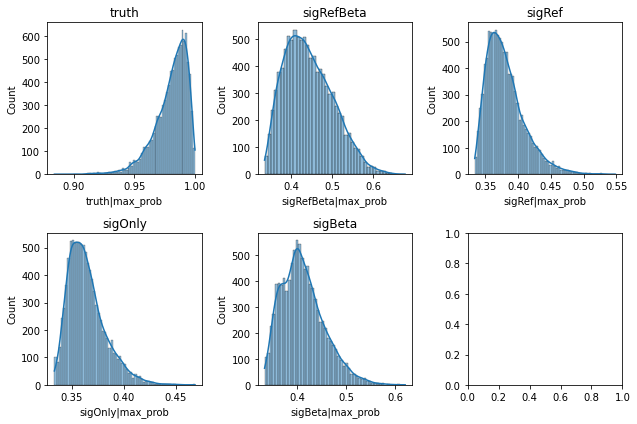

In [35]:
# draw the histogram of max_probs for the different models
model_name_list = ['truth', 'sigRefBeta', 'sigRef', 'sigOnly', 'sigBeta']
plot_nrow = 2
plot_ncol = 3
fig, axes = plt.subplots(ncols = plot_ncol, nrows = plot_nrow, figsize = (9,6))
for model_index, model_name in enumerate(model_name_list[:]):
    ax = (axes.flat)[model_index] 
    sns.histplot(all_df['{}|max_prob'.format(model_name)], kde= True, ax = ax).set_title(model_name)
fig.tight_layout()
plt.show()

Plots of the confusion matrix between the true state assignment (rows) and the predicted state assignment (columns)

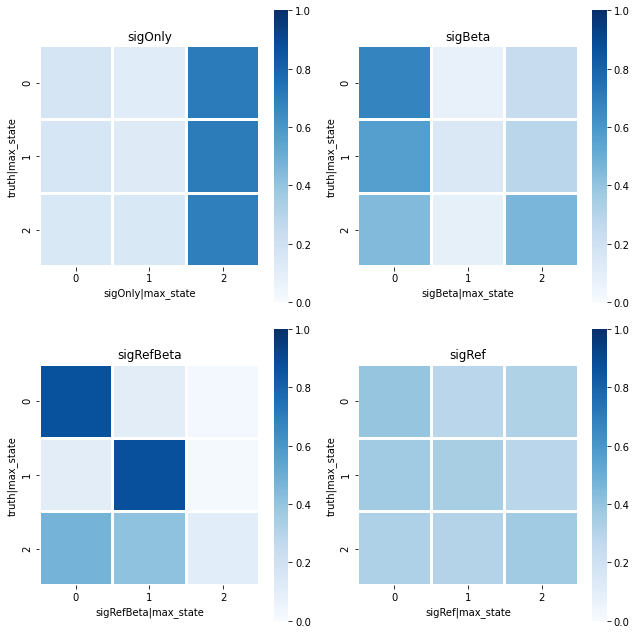

In [37]:
model_name_list = ['truth', 'sigOnly', 'sigBeta', 'sigRefBeta', 'sigRef']
# draw the confusion matrix
state_df = all_df.filter(regex='max_state',axis=1)
# select columns ending with 'max_state'
plot_nrow = 2
plot_ncol = 2
fig, axes = plt.subplots(ncols = plot_ncol, nrows = plot_nrow, figsize = (9,9))
for model_index, model_name in enumerate(model_name_list[1:]):
    colnames = ['truth|max_state', '{}|max_state'.format(model_name)]
    df = state_df[colnames]
    df = df.groupby(colnames).size().to_frame(name = 'size').reset_index()
    df = df.pivot(colnames[0], colnames[1], 'size')
    df = df.div(df.sum(axis = 1), axis = 0) # row normalize
    ax = (axes.flat)[model_index] 
    sns.heatmap(df, cbar=True, linewidths=2,vmax=1, vmin=0, square=True, cmap='Blues', ax=ax).set_title(model_name)
fig.tight_layout()
plt.show()